# **Predicting Popularity with Spotify**
IST 718 - Group 6
Jacob Kahane, Emani Jones, Shivangi Mundhra



# 1. Abstract
Through the course of the last decade the way in which we consume music has changed dramatically. The rise of streaming platforms have alleviated many of the barriers to entry that artists faced previously leading to a drastic increase in the supply of music. With so much content to sift through, the problem then becomes figuring out what music is going to be popular.

Spotify first arrived in the US in 2011 and has since grown to over 400 million active users.. One of the most significant things that sets a streaming platform apart is their ability to put the best music in front of their users. Streaming platforms such as Spotify work to curate playlists for their users full of both songs that are known to be popular as well as new music that has the potential to be.

The overall objective of this project is to develop a prediction algorithm that can be used to predict whether or not a new song being added to a streaming platform will become popular based on the characteristics of the song itself as well as whether or not a specific user will like it.


## 1.1. Data Description
The Data used in this project was originally collected from Spotify using their API and corresponding R package. The dataset contains 32,833 observations across 18 variables. Each observation represents a track located within Spotify’s library. The first 5 variables cover basic information about each track such as title, artist, genre. The remaining 13 variables dig deep into the attributes of each song such as danceability, energy, speechiness. This includes the variable we are most interested in which is popularity.


## 1.2. Prediction
Predict the popularity level of new music that is released on the platform.


1. Predict the popularity level of new music that is released on the platform.
  a. In order to accomplish this, the variable measuring the
overall popularity of the track will be converted to a factor variable with three levels: Low, Medium, and High based on the the 1/3rd and 2/3rd percentiles of the distribution of the track popularity scores.
With the new popularity variable, prediction models using both supervised (Support Vector Machines) and unsupervised (K-Nearest Neighbor) machine learning will be used in order to predict which level of popularity the track will reach.
2. Predict whether an individual user will like a song
Since the original dataset does not contain information about whether or not a user likes a song, a subset of 200 songs will be used. Group members will each go through the list and mark down which songs they like.
Based on the new dummy variables we will use K- means cluster analysis (unsupervised) and logistic regression (supervised) models to try and predict whether each group member will like a song.





## 1.3. Inference


1. Determine whether or not the attributes that influence popularity vary by genre.
The dataset will be split into different genres and then using linear regression the factors that affect the popularity levels of each genre will be determined and compared to see what the differences may be.

2.   Determine which attributes are most related to each other and see if it is affected by genre.
The numeric variables will be used to create a correlation matrix in order to display the relationship between variables.
Additionally, based on the results of the previous inference, we will use principal component analysis to see if the attributes linked together through PCA are similar to those of a specific genre in terms of determining popularity.



# 2. Data Collection and Cleaning


## 2.1. Load Data & Necessary Packages

In [1]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark &> /dev/null


# Download the data files from github
# If the data file does not exist in the colab environment
data_file=spotify.csv
if [[ ! -f ./${data_file} ]]; then
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv &>/dev/null
fi

In [2]:
#Load in any necessary packages
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os
from pyspark.sql.functions import avg
from pyspark.sql.functions import col
from pyspark.sql.functions import isnull
from pyspark.sql.functions import count, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml import feature, regression, Pipeline, pipeline
from pyspark.sql.functions import rand
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
!pip install pyspark_dist_explore

In [4]:
#Read in DataFrame
spotify_df = df = spark.read.csv("/content/spotify_songs.csv", header=True, inferSchema=True)

In [ ]:
#Show top 5 rows
spotify_df.show(5)

+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|6f807x0im

## 2.2. Data Cleaning

In [5]:
rows = spotify_df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(spotify_df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 32833
DataFrame Columns count : 23


### 2.2.1. Correct Data types for numeric columns

In [6]:
# Print the schema of the DataFrame to check data types
spotify_df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)


In [7]:
# List of columns to convert to double data type
double_cols = ['danceability', 'mode', 'loudness', 'energy', 'key']

# Loop over the columns and convert each one to double data type
for col_name in double_cols:
  spotify_df = spotify_df.withColumn(col_name, col(col_name).cast('double'))

In [ ]:
# Print the schema of the DataFrame to check data types of columns
spotify_df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)


In [ ]:
# Show top 5 rows
spotify_df.show(5)

+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|6f807x

### 2.2.2. Remove columns that are not required

In [8]:
#create a list of columns to drop
columns_to_drop = ['track_id', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_subgenre']

#drop columns from list
spotify_df = spotify_df.drop(*columns_to_drop)

In [ ]:
# Show top 5 rows
spotify_df.show(5)

+--------------------+----------------+----------------+--------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|          track_name|    track_artist|track_popularity|playlist_genre|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+--------------------+----------------+----------------+--------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|I Don't Care (wit...|      Ed Sheeran|              66|           pop|       0.748| 0.916| 6.0|  -2.634| 1.0|     0.0583|       0.102|             0.0|  0.0653|  0.518|122.036|   194754.0|
|Memories - Dillon...|        Maroon 5|              67|           pop|       0.726| 0.815|11.0|  -4.969| 1.0|     0.0373|      0.0724|         0.00421|   0.357|  0.693| 99.972|   162600.0|
|All the Time - Do...|    Zara Larsson|           

### 2.2.3. Remove rows where data is null

In [9]:
# Check for missing values in all of the specified columns
missing_values = spotify_df.filter(
    isnull('danceability') | isnull('energy') | isnull('key') |
    isnull('loudness') | isnull('mode') | isnull('speechiness') |
    isnull('acousticness') | isnull('instrumentalness') |
    isnull('liveness') | isnull('valence') | isnull('tempo') |
    isnull('duration_ms') | isnull('track_popularity')
)

# Print the number of missing values in each column
for column in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_popularity']:
    missing_count = missing_values.filter(isnull(column)).count()
    print(f"Number of missing values in '{column}' column: {missing_count}")


Number of missing values in 'danceability' column: 12
Number of missing values in 'energy' column: 1
Number of missing values in 'key' column: 1
Number of missing values in 'loudness' column: 1
Number of missing values in 'mode' column: 1
Number of missing values in 'speechiness' column: 0
Number of missing values in 'acousticness' column: 0
Number of missing values in 'instrumentalness' column: 0
Number of missing values in 'liveness' column: 0
Number of missing values in 'valence' column: 0
Number of missing values in 'tempo' column: 0
Number of missing values in 'duration_ms' column: 0
Number of missing values in 'track_popularity' column: 0


In [10]:
# Remove the records that have null values in any of the specified columns
spotify_df = spotify_df.dropna(
    subset=['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms',
            'track_popularity']
)

# Verify that there are no more missing values
spotify_df.select([count(when(isnull(c), c)).alias(c) for c in spotify_df.columns]).show()

+----------+------------+----------------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|track_name|track_artist|track_popularity|playlist_genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|
+----------+------------+----------------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|         0|           0|               0|             0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|
+----------+------------+----------------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+



### 2.2.4. Rename playlist_genre as genre

In [11]:
#rename column for clarity
spotify_df = spotify_df.withColumnRenamed('playlist_genre', 'genre')

### 2.2.5. Drop Duplicates

In [12]:
# Check number of records before dropping duplicates
print("Number of records before dropping duplicates:", spotify_df.count())

# Drop duplicates
spotify_df = spotify_df.dropDuplicates()

# Check number of records after dropping duplicates
print("Number of records after dropping duplicates:", spotify_df.count())

Number of records before dropping duplicates: 32821
Number of records after dropping duplicates: 30357


In [13]:
rows = spotify_df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(spotify_df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 30357
DataFrame Columns count : 16


## 2.3. Description

After reading in the data set into the colab environment, it was put through several data cleaning and pre-processing steps. The data frame originally contained 32,821 rows across 23 variables. Each row represents a song located within the Spotify libary.

  The first data cleaning step taken was correcting the data types of the variables. After checking the data types of all the variables present in the data set, it could be seen that many of the variables were read in a strings instead of doubles. This was corrected by casting the columns to the correct data type.
  
  Next, all of the unnecessary columns were removed. The initial data set contained several columns of idenitfying features for each song such as title, artist name, album name, track id, and more. These columns were dropped leaving just the characteristics of the songs.
  
  After checking for null values, there was discovered to be a small number of null values present in the dataset. Given the size of the data set, it felt appropriate to drop any observation containing null values as well as any duplicate values that were found.

  The resulting dataframe contained 30,357 observations across 16 variables.

# 3. Preliminary Data Exploration

## 3.1. Correlation Heat Map

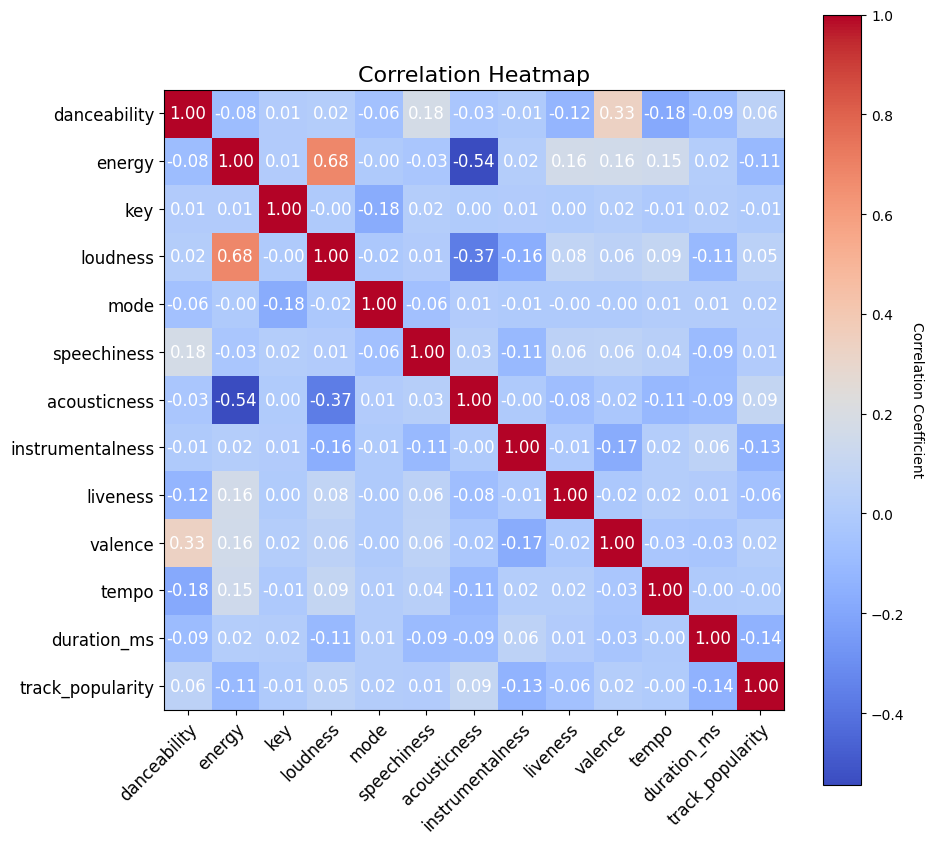

In [ ]:
# Select columns of interest
columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_popularity']

# Create vector of features
assembler = VectorAssembler(inputCols=columns, outputCol='features')
vector_df = assembler.transform(spotify_df).select('features')

# Compute correlation matrix
matrix = Correlation.corr(vector_df, 'features').head()
corr_matrix = matrix[0].toArray()

# Create heatmap using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr_matrix, cmap='coolwarm')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlation Coefficient', rotation=-90, va="bottom")

# Set ticks and labels
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels(columns, fontsize=12)
ax.set_yticklabels(columns, fontsize=12)

# Rotate x-labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(columns)):
    for j in range(len(columns)):
        text = ax.text(j, i, '{:.2f}'.format(corr_matrix[i, j]), ha="center", va="center", color="w", fontsize=12)

# Set title
ax.set_title("Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()

## 3.2. Bar plot of average popularity by genre

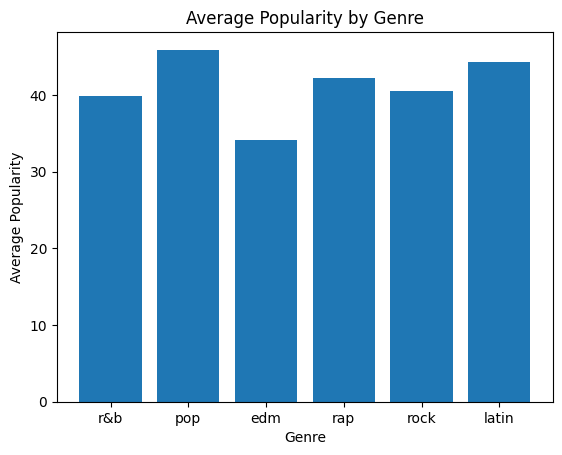

In [ ]:
# Calculate average popularity by genre
avg_popularity_by_genre = spotify_df.groupBy('genre').agg({'track_popularity': 'mean'})

# Convert to Pandas DataFrame
avg_popularity_by_genre_pd = avg_popularity_by_genre.toPandas()

# Create bar plot
plt.bar(avg_popularity_by_genre_pd['genre'], avg_popularity_by_genre_pd['avg(track_popularity)'])
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.title('Average Popularity by Genre')
plt.show()


## 3.3. Density plot of Danceability by Genre

In [ ]:
#Convert to pd dataframe for graphing
spotify_pd = spotify_df.toPandas()

In [ ]:
#display head
spotify_pd.head()

,track_name,track_artist,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Giant (with Rag'n'Bone Man),Calvin Harris,83,pop,0.807,0.887,1.0,-4.311,0.0,0.0361,0.01600,0.000503,0.0811,0.606,122.015,229184.0
1,Sad,Aivarask,56,pop,0.818,0.760,11.0,-7.326,0.0,0.1860,0.19700,0.000094,0.0749,0.365,125.055,175200.0
2,Hurt U,EAUXMAR,40,pop,0.726,0.437,1.0,-7.608,0.0,0.0419,0.34900,0.002150,0.1350,0.223,114.013,187368.0
3,Loud Places,Jamie xx,7,pop,0.646,0.629,8.0,-10.775,0.0,0.0427,0.00426,0.277000,0.1220,0.173,109.013,283067.0
4,Not,Big Thief,62,pop,0.422,0.788,11.0,-6.570,1.0,0.0556,0.10100,0.002820,0.1600,0.544,140.423,367093.0


Text(0.5, 1.0, 'Density plot of danceability by genre')

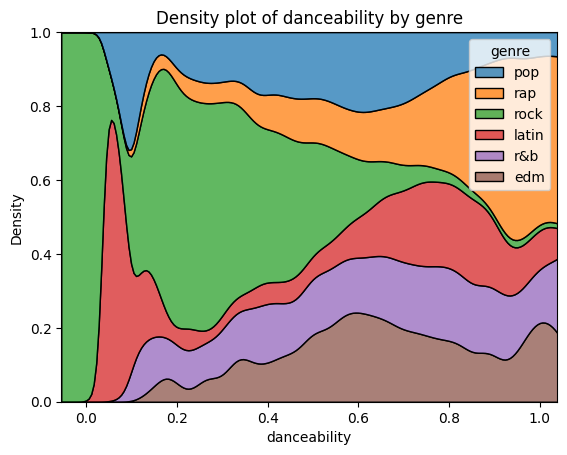

In [ ]:
df_subset = spotify_pd[['genre', 'danceability']]
df_grouped = df_subset.groupby('genre').mean()
df_grouped = df_grouped.reset_index()
sns.kdeplot(data=df_subset, x='danceability', hue='genre', multiple='fill')
plt.title('Density plot of danceability by genre')

## 3.4. Stacked boxplot of Energy by Genre

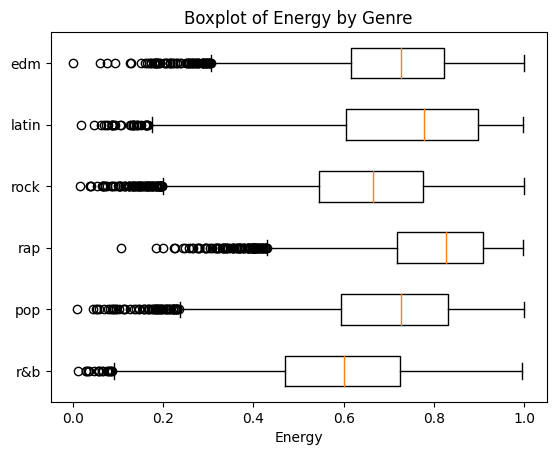

In [ ]:
# Group data by genre and extract energy values as a list for each genre
energy_by_genre = spotify_df.groupby('genre').agg({'energy': 'collect_list'}).toDF('genre', 'energy_list')
energy_rdd = energy_by_genre.select('energy_list').rdd.flatMap(lambda x: x)

# Create boxplot of energy by genre
fig, ax = plt.subplots()
ax.boxplot(energy_rdd.collect(), vert=False)
ax.set_title('Boxplot of Energy by Genre')
ax.set_xlabel('Energy')
ax.set_yticklabels(energy_by_genre.select('genre').rdd.flatMap(lambda x: x).collect())
plt.show()

## 3.5. Density Plot of Valence by Genre

Text(0.5, 1.0, 'Density plot of valence by genre')

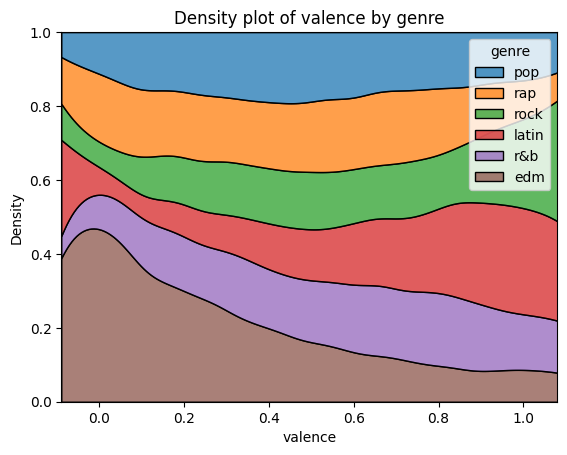

In [ ]:
df_subset = spotify_pd[['genre', 'valence']]
df_grouped = df_subset.groupby('genre').mean()
df_grouped = df_grouped.reset_index()
sns.kdeplot(data=df_subset, x='valence', hue='genre', multiple='fill')
plt.title('Density plot of valence by genre')

## 3.6. Description

With the data cleaned, several visualizations were constructed in order to further investigate the data itself as many patterns cannot be seen by looking at the data alone. The initial visualization created was a correlation heat map for the variables we were interested in for analysis. We did this to ensure that no two variables were so highly correlated that one of them needed to be excluded from the analysis. Loudness and energy were significantly correlated with a correlation value of 0.68, but it was deemed low enough to keep it in the evaluation.

Next, a bar plot was constructed which displayed the average popularity score for each genre represented in the data set: Pop, Rap, Rock, Latin, R&B, and EDM. The resulting bar plot suggested there may be a difference between the characteristics of songs for each genre as the average popularity levels were significantly different.

To further investigate, additional graphs were created looking at the distribution of several of the characteristics of the songs. A density plot of the danceability by genre, a stacked boxplot of the energy by genre, and a density plot of the valence by genre all showed significant variation in the distribution of the characteristics of songs depending on the genre.

# 4. Inferences: Methodology & Results

## 4.1. Regression and Principal Component Analysis

### 4.1.1. Linear regression with each genre as dummy variable to determine if the genre is significant in predicting popularity

In [15]:
# create a StringIndexer to convert the genre column to numeric indices
string_indexer = StringIndexer(inputCol='genre', outputCol='genre_index')

# create a OneHotEncoder to convert the numeric indices to dummy variables
one_hot_encoder = OneHotEncoder(inputCols=['genre_index'], outputCols=['genre_one_hot'])

# create a pipeline to apply both transformers
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder])

# fit the pipeline to the data and transform the data
transformed_data = pipeline.fit(spotify_df).transform(spotify_df)

In [ ]:
transformed_data.show(5)

+--------------------+-------------+----------------+-----+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+-----------+-------------+
|          track_name| track_artist|track_popularity|genre|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|genre_index|genre_one_hot|
+--------------------+-------------+----------------+-----+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+-----------+-------------+
|Giant (with Rag'n...|Calvin Harris|              83|  pop|       0.807| 0.887| 1.0|  -4.311| 0.0|     0.0361|       0.016|         5.03E-4|  0.0811|  0.606|122.015|   229184.0|        2.0|(5,[2],[1.0])|
|                 Sad|     Aivarask|              56|  pop|       0.818|  0.76|11.0|  -7.326| 0.0|      0.186|       0.197|         9.39E-5|  0.0749|  0.365|125.055|   175200.0|       

In [17]:
# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                       'duration_ms', 'genre_one_hot'],
                            outputCol='features')

# Transform the data to include the features vector
data_with_features = assembler.transform(transformed_data)

# Create a linear regression model with regularization parameter alpha=0.0 for no regularization
lr = LinearRegression(featuresCol='features', labelCol='track_popularity', regParam=0.0)

# Split the data into training and testing sets
training_data, testing_data = data_with_features.randomSplit([0.7, 0.3])

# Train the model on the training data
lr_model = lr.fit(training_data)

# Evaluate the model on the testing data
lr_predictions = lr_model.transform(testing_data)

# Print the coefficients and intercept of the linear regression model
print('Coefficients: ', lr_model.coefficients)
print('Intercept: ', lr_model.intercept)

Coefficients:  [9.484700709056016,-25.86278999262232,-0.009777021663084908,1.3718043753268159,0.5146619939417174,-3.742106833717654,3.0958718785726473,-7.988634560030468,-3.0233377260095406,-0.9896310848984284,0.019668775956894178,-4.6017557873990354e-05,-8.225137426050154,-3.9055943491109146,0.08820169702627265,-5.530091048991408,-2.004336030531145]
Intercept:  74.90098569255358


In [ ]:
lr_sum = lr_model.summary
pvals = lr_sum.pValues
coeffs = lr_model.coefficients.toArray().tolist()
vars = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms','rap','rock','latin','r&b', 'edm']
cols = ['Variable','Coefficients', 'P-Values']
lr_out = spark.createDataFrame(zip(vars, coeffs, pvals), cols)
lr_out.show()

+----------------+--------------------+--------------------+
|        Variable|        Coefficients|            P-Values|
+----------------+--------------------+--------------------+
|    danceability|     10.505443655991|2.420286193682841...|
|          energy|  -27.53946898395323|                 0.0|
|             key|0.030834550797185716|  0.4965488298282579|
|        loudness|  1.5297355997345499|                 0.0|
|            mode|  0.6758765730417317|0.042053778590199986|
|     speechiness| -1.6804371875643043| 0.35135970566882246|
|    acousticness|  3.7507892652911643|2.455802614620417E-5|
|instrumentalness|  -7.485991876448945|                 0.0|
|        liveness|  -3.181855823434964|0.002976133501348066|
|         valence| -2.2213103814250474|0.005918880424461426|
|           tempo|0.026576559874304424|1.884857905665171...|
|     duration_ms|-4.57935381744194...|                 0.0|
|             rap|  -8.321808636544215|                 0.0|
|            rock|  -4.0

### 4.1.2. Individual Genre Regressions

In [ ]:
#Split up dataset by genre
pop_df = spotify_df.filter(spotify_df['genre'] == 'pop')
rap_df = spotify_df.filter(spotify_df['genre'] == 'rap')
rock_df = spotify_df.filter(spotify_df['genre'] == 'rock')
latin_df = spotify_df.filter(spotify_df['genre'] == 'latin')
rb_df = spotify_df.filter(spotify_df['genre'] == 'r&b')
edm_df = spotify_df.filter(spotify_df['genre'] == 'edm')

#split each into test and train data
pop_training_data, pop_testing_data = pop_df.randomSplit([0.7, 0.3])
rap_training_data, rap_testing_data = rap_df.randomSplit([0.7, 0.3])
rock_training_data, rock_testing_data = rock_df.randomSplit([0.7, 0.3])
latin_training_data, latin_testing_data = latin_df.randomSplit([0.7, 0.3])
rb_training_data, rb_testing_data = rb_df.randomSplit([0.7, 0.3])
edm_training_data, edm_testing_data = edm_df.randomSplit([0.7, 0.3])

#build vector assembler
va = VectorAssembler(inputCols=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                       'duration_ms'],
                            outputCol='features')

#contruct pipe for linear regression
lr_pipe = Pipeline(stages=[va, lr])

#fit model for each genre
pop_lr_model = lr_pipe.fit(pop_training_data)
rap_lr_model = lr_pipe.fit(rap_training_data)
rock_lr_model = lr_pipe.fit(rock_training_data)
latin_lr_model = lr_pipe.fit(latin_training_data)
rb_lr_model = lr_pipe.fit(rb_training_data)
edm_lr_model = lr_pipe.fit(edm_training_data)

#transform data for each genre
pop_lr_predictions = pop_lr_model.transform(pop_testing_data)
rap_lr_predictions = rap_lr_model.transform(rap_testing_data)
rock_lr_predictions = rock_lr_model.transform(rock_testing_data)
latin_lr_predictions = latin_lr_model.transform(latin_testing_data)
rb_lr_predictions = rb_lr_model.transform(rb_testing_data)
edm_lr_predictions = edm_lr_model.transform(edm_testing_data)

#Pull model coefficients
pop_lr_coeff = pop_lr_model.stages[-1].coefficients.toArray().tolist()
rap_lr_coeff = rap_lr_model.stages[-1].coefficients.toArray().tolist()
rock_lr_coeff = rock_lr_model.stages[-1].coefficients.toArray().tolist()
latin_lr_coeff = latin_lr_model.stages[-1].coefficients.toArray().tolist()
rb_lr_coeff = rb_lr_model.stages[-1].coefficients.toArray().tolist()
edm_lr_coeff = edm_lr_model.stages[-1].coefficients.toArray().tolist()

#pull model summary and resulting p-values
pop_lr_summary = pop_lr_model.stages[-1].summary
pop_lr_pvalues = pop_lr_summary.pValues
rap_lr_summary = rap_lr_model.stages[-1].summary
rap_lr_pvalues = rap_lr_summary.pValues
rock_lr_summary = rock_lr_model.stages[-1].summary
rock_lr_pvalues = rock_lr_summary.pValues
latin_lr_summary = latin_lr_model.stages[-1].summary
latin_lr_pvalues = latin_lr_summary.pValues
rb_lr_summary = rb_lr_model.stages[-1].summary
rb_lr_pvalues = rb_lr_summary.pValues
edm_lr_summary = edm_lr_model.stages[-1].summary
edm_lr_pvalues = edm_lr_summary.pValues

#define the variable names and column names
variables = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms']
columns = ['Variable','Coefficients', 'P-Values']

#combine all three into one dataframe
pop_output = spark.createDataFrame(zip(variables, pop_lr_coeff, pop_lr_pvalues), columns)
rap_output = spark.createDataFrame(zip(variables, rap_lr_coeff, rap_lr_pvalues), columns)
rock_output = spark.createDataFrame(zip(variables, rock_lr_coeff, rock_lr_pvalues), columns)
latin_output = spark.createDataFrame(zip(variables, latin_lr_coeff, latin_lr_pvalues), columns)
rb_output = spark.createDataFrame(zip(variables, rb_lr_coeff, rb_lr_pvalues), columns)
edm_output = spark.createDataFrame(zip(variables, edm_lr_coeff, edm_lr_pvalues), columns)

In [ ]:
#display output of each regression
pop_output.show()
rap_output.show()
rock_output.show()
latin_output.show()
rb_output.show()
edm_output.show()

+----------------+--------------------+--------------------+
|        Variable|        Coefficients|            P-Values|
+----------------+--------------------+--------------------+
|    danceability|  15.400731471838995|9.416613946600094E-6|
|          energy| -26.633400987024444|1.610711564126177...|
|             key| 0.03918043024655019|  0.7230815196974307|
|        loudness|  1.9243378373279747|                 0.0|
|            mode| 0.11071878834695595|   0.892402469167938|
|     speechiness|    24.1956121646929|4.884554881434688...|
|    acousticness|  -1.422741176220875|  0.5302537196618995|
|instrumentalness| -10.027585500743998|8.447217363150017E-6|
|        liveness| -0.7523498910428059|  0.8015766150706289|
|         valence|    -0.7786339077372|   0.710058271765865|
|           tempo|0.004337341417798452|  0.7969995040484368|
|     duration_ms|-4.61408730081579...|6.799989165084952E-7|
+----------------+--------------------+--------------------+

+----------------+-----

### 4.2. Description

The next step in the analysis was to use linear regression to further investigate whether the genre of a song is important in determing the popularity of a song. The first linear regression used an encoder to create a dummy variable with the reference category being the Pop genre. The results of the regression showed that the majority of the genres came back as significant based on the corresponding p-value in terms of predicting the popularity score of a song. It is also interesting to note that all of the coefficients for the genres returned a negative compared to the reference category of Pop.

The results of the individual regressions supported those of the regression with dummy variables. After the initial regression was run, the data was divided into 6 groups based on the genre of the song. Each subset of data was then put through a regression on it own to see if the factors that influence popularity may be different between genres. When looking at the results of the 6 individual regressions there are a couple variables that remain significant all the way through, such as energy staying consistantly negative and significant and loudness staying consistantly positive and significant. However, the remainder of the variables varied in sign and signficance across regressions. This further provides evidence in there being differences between genre.

## 4.3. Principle Component Analysis

In [ ]:
#build and fit pca pipe
pca_spotify = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                       'duration_ms'],
                            outputCol='features'),
    feature.StandardScaler(withStd=True,
                           inputCol='features', outputCol='zfeatures'),
    feature.PCA(k=6, inputCol='zfeatures', outputCol='pc')
]).fit(spotify_df)

In [ ]:
#define model
pca_model = pca_spotify.stages[-1]

#pull out pca loadings
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()
pc3 = pca_model.pc.toArray()[:, 2].tolist()
pc4 = pca_model.pc.toArray()[:, 3].tolist()
pc5 = pca_model.pc.toArray()[:, 4].tolist()
pc6 = pca_model.pc.toArray()[:, 5].tolist()

#combine to dataframe
pc_loadings = pd.DataFrame([variables,pc1,pc2,pc3,pc4,pc5,pc6]).T.rename(columns={0: 'variable',
                                                                                  1: 'load_pc1',
                                                                                  2: 'load_pc2',
                                                                                  3: 'load_pc3',
                                                                                  4: 'load_pc4',
                                                                                  5: 'load_pc5',
                                                                                  6: 'load_pc6'})
#show loading values
pc_loadings

,variable,load_pc1,load_pc2,load_pc3,load_pc4,load_pc5,load_pc6
0,danceability,-0.033432,0.598364,-0.027493,0.306326,-0.075144,-0.291461
1,energy,0.61322,-0.037686,0.011437,0.096749,-0.022083,-0.045679
2,key,0.005402,0.080236,0.674332,0.022894,0.030517,0.272259
3,loudness,0.55407,0.076662,-0.042701,-0.060081,-0.133956,0.101189
4,mode,-0.011599,-0.140063,-0.6778,0.037852,0.101953,-0.037025
5,speechiness,0.002748,0.348351,0.104061,-0.458912,0.071681,-0.40804
6,acousticness,-0.489481,0.052249,-0.033462,-0.232071,0.011342,0.110504
7,instrumentalness,-0.077937,-0.290426,0.183678,0.379576,-0.301016,-0.679693
8,liveness,0.161293,-0.131358,0.093919,-0.350337,0.658861,-0.390169
9,valence,0.114525,0.519194,-0.130667,0.192788,0.19687,0.131724


### 4.4. Description

Principle Component Analysis was also used in order to further the investigation into the influence of genres. PCA was used on the dataset to create 6 components, the same number of genres present in the dataset. The idea being that if the factors intended to predict popularity are so vastly different for each genre, then each of the  PCA components might caputure factors associated with predicting the popularity for a specific genre.

Unfortunately, after comparing the loading level for each variables for each components, there does not appear to be a match for any particular genre.

# 5. Predictions: Methodology & Results

## 5.1. Predicting Popularity

We will classify popularity in two different ways. We firstal calculated the 1/3rd and 2/3rd percentiles of the track popularity scores. Then we created a multiclass column with 3 levels of popularity. Then we created a binary column of whether the song was popular or not.

In [19]:
#Preparation for prediction models

# Calculate the 1/3rd and 2/3rd percentiles of the track popularity scores
from pyspark.sql.functions import udf, when
p1 = spotify_df.approxQuantile("track_popularity", [0.33], 0)[0]
p2 = spotify_df.approxQuantile("track_popularity", [0.67], 0)[0]
# Create a new column with the factor levels based on the percentiles
spotify_df = spotify_df.withColumn("popularity_level",
                  when(spotify_df["track_popularity"] <= p1, 1)
                   .when(spotify_df["track_popularity"] <= p2, 2)
                   .otherwise(3))


#Calculate track popularity as binary. If it is less than 2/3 percentile it is not popular, if it above the 2/3 percentile it is popular
# Create a new column with the factor levels based on the percentiles
spotify_df = spotify_df.withColumn("is_popular",
                  when(spotify_df["track_popularity"] <= p2, 0)
                .otherwise(1))



In [20]:
#Create features & label columns
features_cols = ["danceability", "energy", "key", "loudness", "mode", "speechiness",
                 "acousticness", "instrumentalness", "liveness", "valence", "tempo",'genre_one_hot']



In [21]:
#Split data into test train and validation
train_df, test_df = spotify_df.randomSplit([0.7, 0.3], seed=42)


These data pre-processing steps are essential to prepare the dataset for building predictive models to analyze the relationship between track popularity and other features. We calculate percentiles to create a binary column that indicates whether a track is popular or not. We also create a list of features columns that will be used in the models, and split the data into training and testing datasets to ensure that the models generalize well to new data.

### 5.1.1. Binary Classfiers

We used binary classifiers to predict the value of is_popular column.

#### 5.1.1.1. Logistic Regression

In [22]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
assembler = VectorAssembler(inputCols=features_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')



In [ ]:
#Create the vector assembler and Standard Scaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator


lr = LogisticRegression(featuresCol='scaled_features', labelCol='is_popular')
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder,assembler,scaler, lr])




# Fit the model on the training data
model = pipeline.fit(train_df)

# Make predictions on the test data
predictions = model.transform(test_df)

# Evaluate the model's performance
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="is_popular")
auc = evaluator.evaluate(predictions)
print('Area under ROC:', auc)


Area under ROC: 0.6618234934812419


The output shows an ROC AUC value of 0.66, which indicates that the model has some ability to distinguish between popular and non-popular tracks, but there is room for improvement.






#### 5.1.1.2. SVM

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

svm = LinearSVC(featuresCol="scaled_features", labelCol="is_popular")
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder,assembler,scaler, svm])

# Create a pipeline to assemble the stages

# Create a parameter grid to search over
param_grid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 100]) \
    .build()


# Create an evaluator to use for cross-validation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="is_popular",metricName= "areaUnderROC")

# Create a cross-validator to search over the parameter grid
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)


#Split training data for the sake of time
small_df=train_df.sample(.1)

# Fit the cross-validator to the training data
cv_model = cv.fit(small_df)

# Make predictions on the test data
predictions = cv_model.transform(test_df)

# Evaluate the predictions
auc = evaluator.evaluate(predictions)
print("AUC:", auc)






AUC: 0.6002482301654934


In [ ]:
best_svm = cv_model.bestModel.stages[-1]
print("Best model: {}".format(best_svm))

Best model: LinearSVCModel: uid=LinearSVC_6504ea5ac149, numClasses=2, numFeatures=16


The AUC is 0.6, indicating that the model is able to distinguish between popular and non-popular songs with moderate accuracy. The code also performs cross-validation and hyperparameter tuning using a parameter grid to find the best model. The best model is a LinearSVC model with maxIter=100, which achieves the highest AUC among the tested models.

### 5.1.2. Multiclass Classifiers

#### 5.1.2.1. Decision Trees

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# define the decision tree classifier
dt = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='popularity_level')

# define the pipeline
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder,assembler,scaler, dt])

param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

# make predictions on the test data
evaluator = MulticlassClassificationEvaluator(labelCol='popularity_level', predictionCol='prediction', metricName='accuracy')

cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# fit the model to the training data
cv_model = cv.fit(train_df)

# make predictions on the test data
predictions = cv_model.transform(test_df)

# evaluate the performance of the classifier using accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# get the best model and its hyperparameters
best_dt = cv_model.bestModel.stages[1]
print("Best decision tree model: {}".format(best_dt))

accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 40.95%
Best decision tree model: OneHotEncoderModel: uid=OneHotEncoder_5826929073d2, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1
Accuracy: 40.95%


#### 5.1.2.2. Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

num_trees = [10, 20, 30]  # number of decision trees in the forest
max_depth = [3, 5, 7]  # maximum depth of each decision tree
param_grid = ParamGridBuilder().addGrid(RandomForestClassifier.numTrees, num_trees).addGrid(RandomForestClassifier.maxDepth, max_depth).build()
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='popularity_level')
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder,assembler,scaler, dt])
evaluator = MulticlassClassificationEvaluator(labelCol='popularity_level', predictionCol='prediction', metricName='accuracy')
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cv_model = cv.fit(train_df)
predictions = cv_model.transform(test_df)



In [ ]:
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))
best_rf = cv_model.bestModel.stages[-1]
print("Best model: {}".format(best_rf))

Accuracy: 40.97%
Best model: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ec4c7cb6b422, depth=5, numNodes=51, numClasses=4, numFeatures=11


#### 5.1.2.3. Naive Bayes

In [ ]:
#removing negative values
naive_train = train_df.filter(
    (col('danceability') >= 0) & (col('energy') >= 0) & (col('key') >= 0) & (col('loudness') >= 0) & (col('mode') >= 0) &
    (col('speechiness') >= 0) & (col('acousticness') >= 0) & (col('instrumentalness') >= 0) & (col('liveness') >= 0) &
    (col('valence') >= 0) & (col('tempo') >= 0) & (col('duration_ms') >= 0)
)

naive_test = test_df.filter(
    (col('danceability') >= 0) & (col('energy') >= 0) & (col('key') >= 0) & (col('loudness') >= 0) & (col('mode') >= 0) &
    (col('speechiness') >= 0) & (col('acousticness') >= 0) & (col('instrumentalness') >= 0) & (col('liveness') >= 0) &
    (col('valence') >= 0) & (col('tempo') >= 0) & (col('duration_ms') >= 0)
)


In [ ]:

string_indexer = StringIndexer(inputCol="genre", outputCol="genre_index", handleInvalid="keep")

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# set up the Naive Bayes classifier and the parameter grid for cross-validation
smoothing = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Laplace smoothing parameter
param_grid = ParamGridBuilder().addGrid(NaiveBayes.smoothing, smoothing).build()
nb = NaiveBayes(featuresCol='scaled_features', labelCol='popularity_level')
pipeline = Pipeline(stages=[assembler,scaler, nb])
evaluator = MulticlassClassificationEvaluator(labelCol='popularity_level', predictionCol='prediction', metricName='accuracy')
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# train the Naive Bayes classifier with cross-validation
cv_model = cv.fit(naive_train)

# make predictions on the test data
predictions = cv_model.transform(naive_test)

# evaluate the performance of the classifier using accuracy

accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# get the best model and its hyperparameters
best_model = cv_model.bestModel
print("Best model: {}".format(best_model))


Accuracy: 50.00%
Best model: PipelineModel_77ccd263470f


### 5.1.3. Description

The chart below summarizes the model accuracies for all models that we have see above. Among the Binary classifiers, Logistic Regression has the best Area under curve while among the multi-class classifiers, Naive Bayes shows the best accuracy.

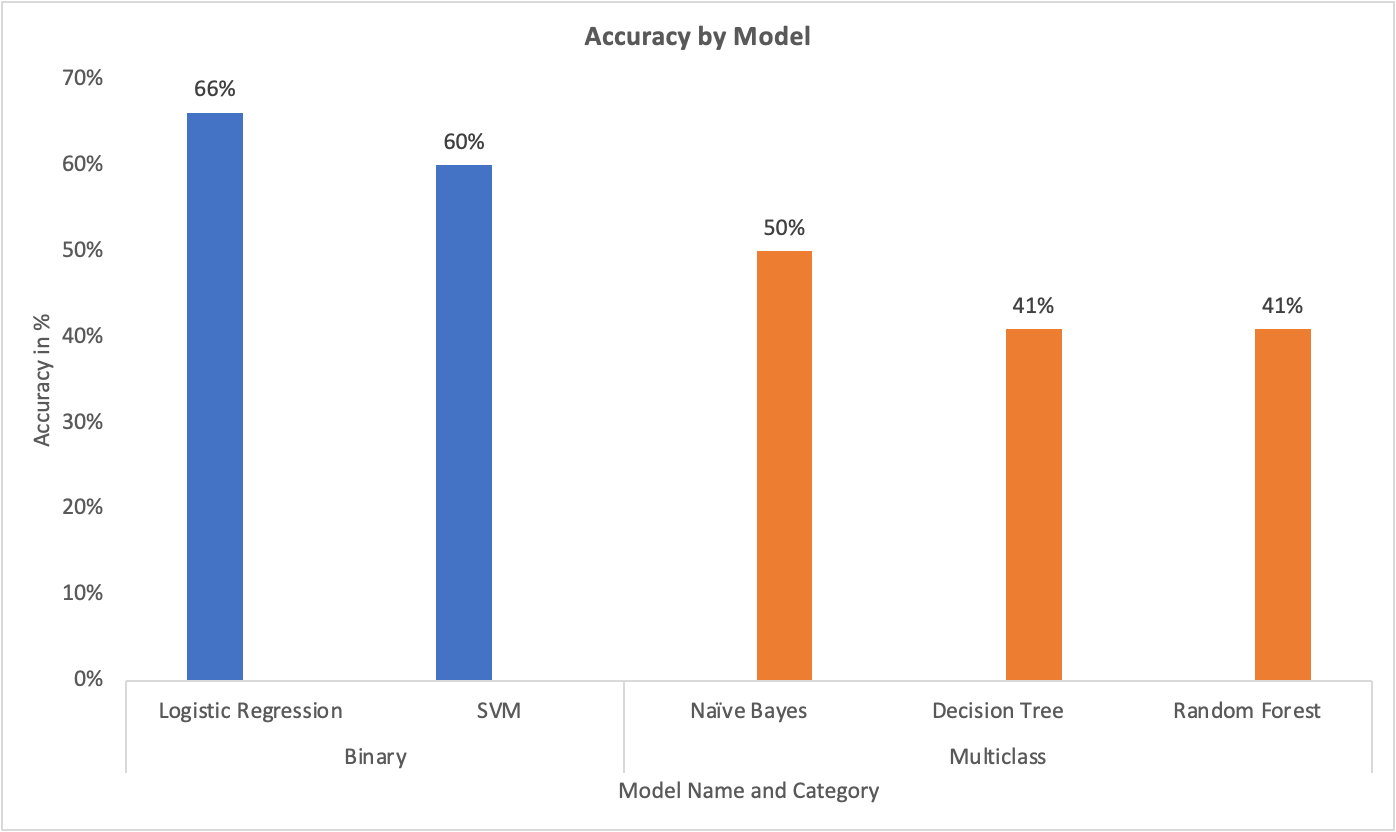

## 5.2. Predicting whether a user likes a song

In [ ]:
#Take subset of 300 songs from original dataset with equal distribution of each genre
sample_spotify = spotify_df.sample(0.01)

#Assign a binary variable with a value of 1 if a user likes the song and a value of 0 if a user does not like a song
sample_spotify = sample_spotify.withColumn('Like', when(rand() > 0.5, 1).otherwise(0))

#Split data into test and train
samp_training_data, samp_testing_data = sample_spotify.randomSplit([0.7, 0.3])

#create standard scalar
ss = feature.StandardScaler(withStd=True, inputCol='features', outputCol='zfeatures')

#build regression model
lr = LogisticRegression().\
    setLabelCol('Like').\
    setFeaturesCol('zfeatures')


In [ ]:
#Create Logistic regression pipe, fit, & transform
logistic_pipe = Pipeline(stages=[va,ss,lr]).fit(samp_training_data)

sample_logistic_predictions = logistic_pipe.transform(samp_testing_data)

#Calculate accuracy
evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
auc = evaluator.evaluate(sample_logistic_predictions)
print('Cross Validator AUC: ', auc)

Cross Validator AUC:  0.45610119047619047


In [ ]:
#Create decision tree pipe, fit & transform
dt = DecisionTreeClassifier(labelCol="Like", featuresCol="features")

dt_model = Pipeline(stages=[va,ss,dt]).fit(samp_training_data)

sample_dt_predictions = dt_model.transform(samp_testing_data)

#Calculate accuracy and compare results with those of logistic regression model
dt_evaluator = BinaryClassificationEvaluator(labelCol=dt.getLabelCol(), rawPredictionCol=dt.getRawPredictionCol())

dt_auc = dt_evaluator.evaluate(sample_dt_predictions)

print('Cross Validator AUC: ', dt_auc)

Cross Validator AUC:  0.46781994047619047


### 5.2.1. Description

Not only is it important for streaming platforms to be able to predict the overall popularity of a song, but it is also vitally important for them to be able to predict whether an individual user will like a song. In an attempt to do this a new subset a data was taken from the original dataset. The subset contained 300 songs or roughly 1% of the original dataset. We then created a new variable called "like" which takes a value of 1 if a user likes the song and a value of 0 if a user does not like a song. Since this data was not available through spotify the value of 0 or 1 was randomly assigned to the 300 songs that were taken as part of the subset of data.

Using the new subset of data two different prediction models were created in an attempt to predict a user liking a song. Those two methods were logisitic regression and Decision Trees. The models were then evaluated based on the resulting AUC scores. The AUC of the logistic model was 0.4561 and the AUC of the Decision Tree model was 0.4678. Based on the AUC scores, the Decision Tree model narrowly beats out the logistics model. However, neither of the scores are particularly high. This is likely because we just randomly assigned a value of 0 or 1 for user preference, most user would likely have a more decernable pattern in terms of songs they like.

### 5.2.2. K Means Clustering for Song Recomendations

In [23]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=6)
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder,assembler,scaler, kmeans])
# fit pipeline to data
model = pipeline.fit(spotify_df)

# get cluster assignments for each song
clustered_data = model.transform(spotify_df)



In [30]:
beyonce = spotify_df.filter(spotify_df['track_name'] == 'Me, Myself and I')
beyonce.show()

+----------------+------------+----------------+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+----------------+----------+
|      track_name|track_artist|track_popularity|genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|popularity_level|is_popular|
+----------------+------------+----------------+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+----------------+----------+
|Me, Myself and I|     Beyoncé|              66|  r&b|        0.75| 0.458|1.0|  -9.092| 1.0|     0.0803|       0.226|         3.25E-5|   0.137|  0.536|83.61|   301133.0|               3|         1|
+----------------+------------+----------------+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+----------------+----------+



In [33]:
# select a random song from the data as the user's current listening preference
user_song = spotify_df.filter(spotify_df['track_name'] == 'Me, Myself and I')

# find the cluster that the user's current song belongs to
user_cluster =model.transform(user_song).select("prediction").collect()[0][0]

# find other songs in the same cluster as the user's current song
recommended_songs = clustered_data.filter(col("prediction") == user_cluster).limit(20)

# print the recommended songs
recommended_songs.show()

+--------------------+-------------------+----------------+-----+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+------+-----------+----------------+----------+-----------+-------------+--------------------+--------------------+----------+
|          track_name|       track_artist|track_popularity|genre|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|duration_ms|popularity_level|is_popular|genre_index|genre_one_hot|            features|     scaled_features|prediction|
+--------------------+-------------------+----------------+-----+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+------+-----------+----------------+----------+-----------+-------------+--------------------+--------------------+----------+
|    Brothers In Arms|       Dire Straits|              24|  pop|       0.413| 0.296| 8.0| -13.904| 0.0|     0.0277|       0.531| 

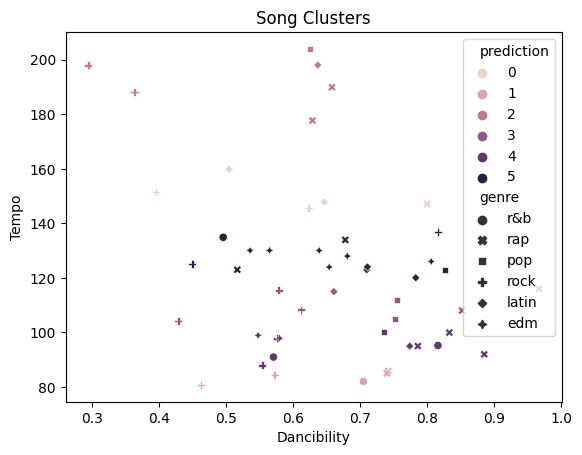

In [ ]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

clusters_df = clustered_data.toPandas()
sample_df = clusters_df.sample(n=50)
# Create a scatter plot with different colors based on genre
sns.scatterplot(data=sample_df, x="danceability", y="tempo", hue="prediction",style='genre')

# Set the title and labels for the plot
plt.title("Song Clusters")
plt.xlabel("Dancibility")
plt.ylabel("Tempo")

# Show the plot
plt.show()




# 6. Conclusion

The initial data exploration indicates significant differences in the distribution of key variables between genres. The regression analysis reveals that although there are some similarities between genres, the factors that determine popularity differ. The results from the principal component analysis (PCA) do not align with any specific genre regression, suggesting that the factors do not aid in predicting the popularity of a particular genre. For predicting user preference, the Decision tree model slightly outperformed the logistic regression model, although the area under the curve (AUC) levels for both models were low, which can be attributed to the random assignment of user preferences. Additionally, binary classifiers performed better than multiclass classifiers. Finally, out of the multiclass classifiers, Naive Bayes yielded the best performance.

Challenges/Limitiations


* Time was an issue, some of the models took a really long time to run
* Our classifiers did not have a high accuracy. Which may be due to the fact that factors such as playlisting, radio play and whether the song is released indepently are all big factors that determine whether a song becomes popular or not.That information was not includedd in the dataset



